In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.fft as fft
import os
from tqdm import tqdm # 打印进度条
import math
from einops import rearrange, repeat, reduce
from scipy.fftpack import next_fast_len
import matplotlib.pyplot as plt
import functools
from functools import partial, wraps
from sympy import Poly, legendre, Symbol, chebyshevt
from scipy.special import eval_legendre
from scipy import signal
from torch.nn.modules.linear import Linear
from torch.nn.utils import weight_norm 
from operator import mul
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
import joblib
# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go

import warnings

warnings.filterwarnings("ignore")

# 基于LSTM（长短时记忆）的时间序列预测

**数据输入维度一般为(样本数,时间步,特征)**

## 多输入多输出多步预测

### 数据准备

In [1]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [3]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [478]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [1]:
# 包含时间维度的数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    #验证集
    valid = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
    valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
    valid_stamp = valid_stamp.transpose(1, 0)
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')
    yva = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')
    valid = [xva, yva, valid_stamp]

    #测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]
    
    return x_scaler, y_scaler, train, valid, test

In [480]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/LSTM'
}

#函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (23376, 2) y_train shape: (23376, 2) stamp_train shape: (23376, 4)
x_valid shape: (1464, 2) y_valid shape: (1464, 2) stamp_valid shape: (1464, 4)
x_test shape: (1464, 2) y_test shape: (1464, 2) stamp_test shape: (1464, 4)


In [5]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0] # 特征
    target = data_list[1] # 目标
    stamp = data_list[2] # 时间戳
    
    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []
    seq_len = seq_len - 1 # 包含当前时间点
    for i in range(seq_len, len(feature) - pred_len, sample_freq):
        # 数据维度
        feat = feature[i - seq_len:i + 1]
        tar = target[i + 1:i + 1 + pred_len]
        X.append(feat)
        y.append(tar)
        
        # 时间维度
        xs = stamp[i - seq_len:i + 1]
        ys = stamp[i + 1 - label_len:i + 1 + pred_len]
        X_stamp.append(xs)
        y_stamp.append(ys)
        
    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()
    
    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()
    
    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)
    
    return X, y, X_stamp, y_stamp, data_loader

In [482]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "label_len": 0,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


### 模型定义

In [483]:
# LSTM模型
class LSTM(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, c_out, d_model, num_layers):
        super().__init__()
        self.pred_len = pred_len
        self.lstm = nn.LSTM(input_size=c_in, hidden_size=d_model, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=d_model, out_features=c_out)
    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        x, _ = self.lstm(x_enc)
        x = self.linear(x)
        x = x[:, -self.pred_len:, :]  # [B, L, D]

        return x

### 模型训练

In [484]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] # 预测长度
    label_len = model_args['label_len']
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) # 会用到实际数据
            batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入 
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            if features == 'MS':
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                # outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                # outputs = outputs[:, :, f_dim:]
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) # 会用到实际数据
                batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                if features == 'MS':
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    # outputs = outputs[:, :, f_dim: f_dim+1] 
                else:
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    # outputs = outputs[:, :, f_dim:]
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:08<02:33,  8.08s/it]

Epoch [1/20], Training Loss: 0.0137, Validation Loss: 0.0055
Validation loss decreased (inf --> 0.005504).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:16<02:26,  8.13s/it]

Epoch [2/20], Training Loss: 0.0052, Validation Loss: 0.0041
Validation loss decreased (0.005504 --> 0.004092).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [00:24<02:17,  8.11s/it]

Epoch [3/20], Training Loss: 0.0043, Validation Loss: 0.0035
Validation loss decreased (0.004092 --> 0.003534).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [00:32<02:09,  8.08s/it]

Epoch [4/20], Training Loss: 0.0039, Validation Loss: 0.0034
Validation loss decreased (0.003534 --> 0.003378).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [00:40<02:00,  8.07s/it]

Epoch [5/20], Training Loss: 0.0036, Validation Loss: 0.0034
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [00:48<01:52,  8.06s/it]

Epoch [6/20], Training Loss: 0.0034, Validation Loss: 0.0032
Validation loss decreased (0.003378 --> 0.003190).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [00:56<01:44,  8.02s/it]

Epoch [7/20], Training Loss: 0.0032, Validation Loss: 0.0027
Validation loss decreased (0.003190 --> 0.002723).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [01:04<01:36,  8.03s/it]

Epoch [8/20], Training Loss: 0.0030, Validation Loss: 0.0025
Validation loss decreased (0.002723 --> 0.002479).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [01:12<01:28,  8.01s/it]

Epoch [9/20], Training Loss: 0.0029, Validation Loss: 0.0024
Validation loss decreased (0.002479 --> 0.002449).  Saving model ...
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [01:20<01:20,  8.00s/it]

Epoch [10/20], Training Loss: 0.0029, Validation Loss: 0.0024
Validation loss decreased (0.002449 --> 0.002416).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [01:28<01:12,  8.02s/it]

Epoch [11/20], Training Loss: 0.0028, Validation Loss: 0.0023
Validation loss decreased (0.002416 --> 0.002278).  Saving model ...
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:36<01:03,  7.96s/it]

Epoch [12/20], Training Loss: 0.0027, Validation Loss: 0.0023
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:44<00:55,  7.96s/it]

Epoch [13/20], Training Loss: 0.0027, Validation Loss: 0.0022
Validation loss decreased (0.002278 --> 0.002239).  Saving model ...
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:52<00:47,  7.99s/it]

Epoch [14/20], Training Loss: 0.0026, Validation Loss: 0.0022
Validation loss decreased (0.002239 --> 0.002152).  Saving model ...
Updating learning rate to 0.00020610737385376348


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:00<00:39,  7.99s/it]

Epoch [15/20], Training Loss: 0.0026, Validation Loss: 0.0022
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00014644660940672628


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [02:08<00:31,  7.97s/it]

Epoch [16/20], Training Loss: 0.0025, Validation Loss: 0.0021
Validation loss decreased (0.002152 --> 0.002119).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [02:16<00:23,  7.97s/it]

Epoch [17/20], Training Loss: 0.0025, Validation Loss: 0.0021
EarlyStopping counter: 1 out of 3
Updating learning rate to 5.449673790581611e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [02:24<00:16,  8.02s/it]

Epoch [18/20], Training Loss: 0.0025, Validation Loss: 0.0021
Validation loss decreased (0.002119 --> 0.002112).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [02:32<00:07,  7.98s/it]

Epoch [19/20], Training Loss: 0.0025, Validation Loss: 0.0021
Validation loss decreased (0.002112 --> 0.002098).  Saving model ...
Updating learning rate to 6.15582970243117e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.00s/it]

Epoch [20/20], Training Loss: 0.0024, Validation Loss: 0.0021
Validation loss decreased (0.002098 --> 0.002091).  Saving model ...
Updating learning rate to 0.0


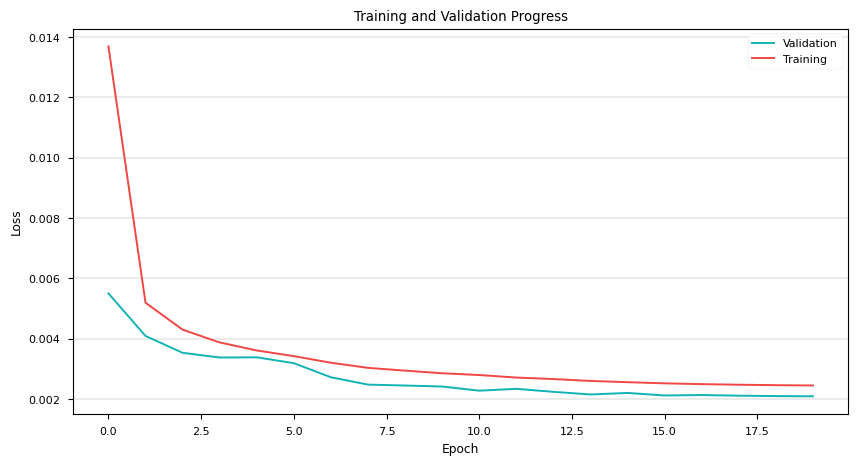

In [485]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "train_args": {
        "model_name": LSTM,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "device": 'cuda',
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/LSTM",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        "label_len": 0,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'num_layers': 1,
    },
}
model = train(**params3)

### 模型测试

In [486]:
def test(task_args, test_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    model = test_args['model'] 
    x_test = test_args['x_test'] 
    x_test_stamp = test_args['x_test_stamp']
    y_test = test_args['y_test'] 
    y_test_stamp = test_args['y_test_stamp']
    pred_len = test_args['pred_len'] 
    label_len = test_args['label_len']
    device = test_args['device'] # 训练设备，可选'cuda'和'cpu'
    test_path = test_args['test_path'] # 结果保存路径
    
    #检查是否可用GPU
    device = torch.device(device)

    # 评估指标函数
    def metric(pred, true):
        # a/b，其中生成的 NaN 或 Inf 替换为 0
        def divide_no_nan(a, b):
            result = a / b
            result[result != result] = .0
            result[np.inf in result] = .0
            result[np.nan in result] = .0
            return result
        # 残差的标准误差
        def RSE(pred, true):
            return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))
        # 相关系数
        def CORR(pred, true):
            u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
            d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
            return (u / d).mean(-1)
        # 平均绝对误差
        def MAE(pred, true):
            return np.mean(np.abs(pred - true))
        # 均方误差
        def MSE(pred, true):
            return np.mean((pred - true) ** 2)
        # 均方根误差
        def RMSE(pred, true):
            return np.sqrt(MSE(pred, true))
        # 平均绝对百分比误差
        def MAPE(pred, true):
            return np.mean(np.abs(divide_no_nan((pred - true), true)))
        # 均方预测误差
        def MSPE(pred, true):
            return np.mean(np.square(divide_no_nan((pred - true), true)))
        # 结果汇总
        mae = MAE(pred, true)
        mse = MSE(pred, true)
        rmse = RMSE(pred, true)
        mape = MAPE(pred, true)
        mspe = MSPE(pred, true)
        print("mae: {:.4f}\nmse: {:.4f}\nrmse: {:.4f}\nmape: {:.4f}\nmspe: {:.4f}".format(mae, mse, rmse, mape, mspe))
        return mae, mse, rmse, mape, mspe
    
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        dec_inp = torch.zeros_like(y_test[:, -pred_len:, :]).float()
        dec_inp = torch.cat([y_test[:, -label_len:, :], dec_inp], dim=1).float().to(device)
        outputs = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
        if features == 'MS':
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            # y_pred = outputs[:, :, f_dim: f_dim+1] 
        else:
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            # y_pred = outputs[:, :, f_dim:]
        # 评估指标计算
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_test.cpu().detach().numpy()
        mae, mse, rmse, mape, mspe = metric(y_pred, y_true)
        np.save(test_path + '/metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(test_path + '/pred.npy', y_pred)
        np.save(test_path + '/true.npy', y_true)
        
    return 0

In [487]:
# 构造参数字典
params4 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "test_args": {
        "model": model,
        "x_test": X_test,
        "x_test_stamp": X_test_stamp,
        "y_test": y_test,
        "y_test_stamp": y_test_stamp,
        'label_len': 0,
        'pred_len': 3,
        'device': 'cuda',
        'test_path': '../outputs/results/LSTM'
    }
}
res = test(**params4)

mae: 0.0344
mse: 0.0027
rmse: 0.0515
mape: 0.0861
mspe: 0.0183


### 结果分析

In [488]:
def plot(task_args, plot_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    drawing_point = plot_args['drawing_point'] # 绘图点
    model = plot_args['model'] 
    x_train = plot_args['x_train'] 
    x_train_stamp = plot_args['x_train_stamp']
    x_valid = plot_args['x_valid'] 
    x_valid_stamp = plot_args['x_valid_stamp']
    x_test = plot_args['x_test'] 
    x_test_stamp = plot_args['x_test_stamp']
    y_train = plot_args['y_train'] 
    y_train_stamp = plot_args['y_train_stamp']
    y_valid = plot_args['y_valid'] 
    y_valid_stamp = plot_args['y_valid_stamp']
    y_test = plot_args['y_test'] 
    y_test_stamp = plot_args['y_test_stamp']
    y_true = plot_args['y_true'] 
    seq_len = plot_args['seq_len']
    scaler = plot_args['scaler']
    pred_len = plot_args['pred_len'] 
    label_len = plot_args['label_len']
    device = plot_args['device'] # 训练设备，可选'cuda'和'cpu'
    option = plot_args['option'] # 绘图选项，可选'part','full'
    figure_path = plot_args['figure_path'] # 图片保存路径
    seq_len = seq_len - 1 # 包含当前时间点
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 任务分类
    def forecasting_task(columns, target, features, drawing_point):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0

        if drawing_point in columns:
            d_dim = col_dict[drawing_point]
        else:
            d_dim = 0
        return f_dim, d_dim
    f_dim, d_dim = forecasting_task(columns, target, features, drawing_point)
        
    # 数据集长度
    train_size = len(x_train) + seq_len + pred_len
    valid_size = len(x_valid) + seq_len + pred_len
    test_size = len(x_test) + seq_len + pred_len
    
    # 时间序列形状
    timeseries_y = y_true.values[:, d_dim].reshape(-1, 1)
    timeseries_x = y_true.index
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''训练集设置'''
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_train_stamp = x_train_stamp.to(device)
        y_train_stamp = y_train_stamp.to(device)
        # decoder输入
        B, _, _ = x_train.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_train[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_train, x_train_stamp, dec_inp, y_train_stamp)
            y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_train[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_train, x_train_stamp, dec_inp, y_train_stamp)
            y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
        train_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        x_valid_stamp = x_valid_stamp.to(device)
        y_valid_stamp = y_valid_stamp.to(device)
        # decoder输入
        B, _, _ = x_valid.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_valid[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_valid, x_valid_stamp, dec_inp, y_valid_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_valid[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_valid, x_valid_stamp, dec_inp, y_valid_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
        valid_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        B, _, _ = x_test.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
        test_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, )) + [np.nan]*(pred_len-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
        
    # 设置保存图片路径
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    figure_path = figure_path + '/' + target[0] + '_' + option + '.png'

    # 全局静态图
    def static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path):
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
        ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
        ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 局部静态图
    def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 全局动态图
    def dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加训练预测数据
        fig.add_trace(
            go.Scatter(
                x=train_plot_x,
                y=train_plot_y,
                mode='lines',
                name='train_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加验证预测数据
        fig.add_trace(
            go.Scatter(
                x=valid_plot_x,
                y=valid_plot_y,
                mode='lines',
                name='valid_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='test_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 局部动态图
    def dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 绘图选项，可选'part','full','dynamic_part','dynamic_full'
    if option == 'part':
        # 局部静态图
        static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'full':
        # 全局静态图
        static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'dynamic_full':
        # 全局动态图
        dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)
    elif option == 'dynamic_part':
        # 局部动态图
        dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y)
    else:
        raise ValueError("only support 'part','full','dynamic_part','dynamic_part'")
        
    return 0

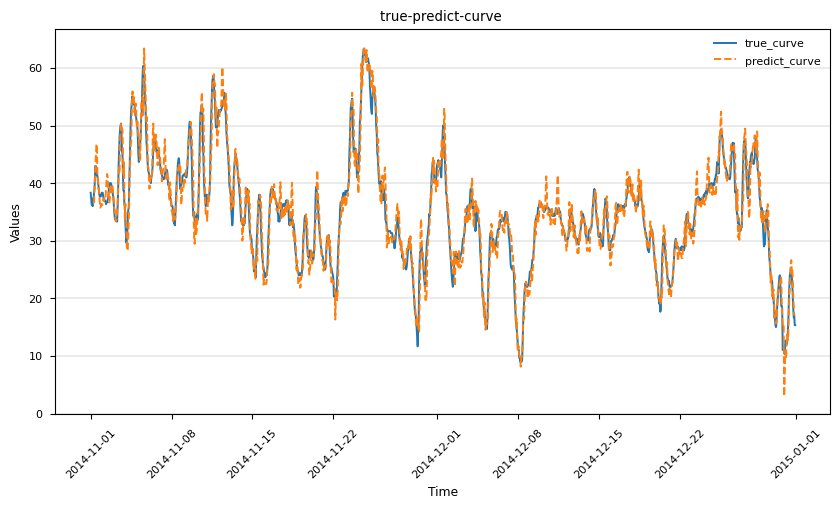

0

In [489]:
# 构造参数字典
params5 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "plot_args": {
        "drawing_point": 'temp',
        "model": model,
        "x_train": X_train,
        "x_valid": X_valid,
        "x_test": X_test,
        "x_train_stamp": X_train_stamp,
        "x_valid_stamp": X_valid_stamp,
        "x_test_stamp": X_test_stamp,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test,
        "y_train_stamp": y_train_stamp,
        "y_valid_stamp": y_valid_stamp,
        "y_test_stamp": y_test_stamp,
        "y_true": ts_data,
        "seq_len": 6,
        "pred_len": 3,
        "label_len": 0,
        "scaler": y_scaler,
        "device": 'cuda',
        "option": 'part',
        "figure_path": '../outputs/images/LSTM'
    }
}
plot(**params5)

### 模型预测

In [490]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    time_col = predict_args['time_col']
    features = task_args['features'] 
    freq = predict_args['freq']
    model_name = predict_args['model_name'] 
    x_true = predict_args['x_true'] 
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path'] 
    device = predict_args['device'] # 预测设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] 
    label_len = model_args['label_len']

    #检查是否可用GPU
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 生成固定长度的时间范围
    x_true = get_dataset(data_path=None, data=x_true, time_col=time_col) # 原始数据
    x_true = x_true[columns]
    timedelta = x_true.index[-1] - x_true.index[-2] # 时间差
    if label_len != 0:
        y_stamp = pd.date_range(start=x_true.index[-label_len], 
                                end=x_true.index[-label_len]+timedelta*(label_len+pred_len-1), 
                                freq=freq)
    else:
        y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(label_len+1), 
                                end=x_true.index[-1]+timedelta*(label_len+pred_len), 
                                freq=freq) 
    x_stamp = time_features(pd.to_datetime(x_true.index), freq=freq) # x时间戳数据
    x_stamp = x_stamp.transpose(1, 0)
    y_time = y_stamp
    y_stamp = time_features(y_stamp, freq=freq) # y时间戳数据
    y_stamp = y_stamp.transpose(1, 0)
    

    # 转换类型
    x_true[columns] = x_scaler.transform(x_true) # 归一化
    x_true = x_true.values.astype('float32')
    x_true = torch.as_tensor(x_true).unsqueeze(0).float() # 转为张量
    x_stamp = torch.as_tensor(x_stamp).unsqueeze(0).float()
    y_stamp = torch.as_tensor(y_stamp).unsqueeze(0).float()
    
    # 任务分类
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)

    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        x_true = x_true.to(device)
        x_stamp = x_stamp.to(device)
        y_stamp = y_stamp.to(device)
        # decoder输入
        B, _, _ = x_true.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'MS':
            dec_inp = torch.cat([x_true[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :]) # 反归一化
            # y_pred = y_pred[:, f_dim: f_dim+1]
        else:
            dec_inp = torch.cat([x_true[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_true, x_stamp, dec_inp, y_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = y_scaler.inverse_transform(y_pred[-1, :, :]) # 反归一化
            # y_pred = y_pred[:, f_dim:]

    # 输出为dataframe
    y_pred = pd.DataFrame(data=y_pred, index=y_time[-pred_len:], columns=target)
    
    return y_pred

In [491]:
# 构造参数字典
params6 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M',
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": LSTM,
        "model_path": "../outputs/best_models/LSTM/checkpoint.pth",
        "x_true": pd.read_csv(data_path).iloc[:6, :],
        "scaler_path": '../outputs/scalers/LSTM',
        "device": 'cpu'
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        "label_len": 0,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'num_layers': 1,
    },
}
y_pred = predict(**params6)

In [492]:
y_pred

,load,temp
2012-01-01 06:00:00,3035.406982,30.113916
2012-01-01 07:00:00,3176.142090,31.012014
2012-01-01 08:00:00,3196.789795,31.459496


# 基于GRU（门控循环单元）的时间序列预测

**数据输入维度一般为(样本数,时间步,特征)**

## 多输入多输出多步预测

### 数据准备

In [2]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [504]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [505]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [2]:
# 包含时间维度的数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    #验证集
    valid = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
    valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
    valid_stamp = valid_stamp.transpose(1, 0)
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')
    yva = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')
    valid = [xva, yva, valid_stamp]

    #测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]
    
    return x_scaler, y_scaler, train, valid, test

In [507]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load", 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/GRU'
}

#函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (23376, 2) y_train shape: (23376, 2) stamp_train shape: (23376, 4)
x_valid shape: (1464, 2) y_valid shape: (1464, 2) stamp_valid shape: (1464, 4)
x_test shape: (1464, 2) y_test shape: (1464, 2) stamp_test shape: (1464, 4)


In [6]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0] # 特征
    target = data_list[1] # 目标
    stamp = data_list[2] # 时间戳
    
    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []
    seq_len = seq_len - 1 # 包含当前时间点
    for i in range(seq_len, len(feature) - pred_len, sample_freq):
        # 数据维度
        feat = feature[i - seq_len:i + 1]
        tar = target[i + 1:i + 1 + pred_len]
        X.append(feat)
        y.append(tar)
        
        # 时间维度
        xs = stamp[i - seq_len:i + 1]
        ys = stamp[i + 1 - label_len:i + 1 + pred_len]
        X_stamp.append(xs)
        y_stamp.append(ys)
        
    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()
    
    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()
    
    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)
    
    return X, y, X_stamp, y_stamp, data_loader

In [509]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "label_len": 0,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3, 2]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3, 2]),loader_len: 46


### 模型定义

In [510]:
# GRU模型
class GRU(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, c_in, c_out, d_model, num_layers):
        super().__init__()
        self.pred_len = pred_len
        self.gru = nn.GRU(input_size=c_in, hidden_size=d_model, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=d_model, out_features=c_out)
    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        x, _ = self.gru(x_enc)
        x = self.linear(x)
        x = x[:, -self.pred_len:, :]  # [B, L, D]

        return x

### 模型训练

In [511]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    features = task_args['features'] # 模型预测模式
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] # 预测长度
    label_len = model_args['label_len']
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 训练任务
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) # 会用到实际数据
            batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入 
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            if features == 'MS':
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                # outputs = outputs[:, :, f_dim: f_dim+1] 
            else:
                dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                # outputs = outputs[:, :, f_dim:]
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) # 会用到实际数据
                batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                if features == 'MS':
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    # outputs = outputs[:, :, f_dim: f_dim+1] 
                else:
                    dec_inp = torch.cat([batch_x[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                    # outputs = outputs[:, :, f_dim:]
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:02<00:55,  2.94s/it]

Epoch [1/20], Training Loss: 0.0134, Validation Loss: 0.0053
Validation loss decreased (inf --> 0.005302).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:05<00:51,  2.88s/it]

Epoch [2/20], Training Loss: 0.0048, Validation Loss: 0.0042
Validation loss decreased (0.005302 --> 0.004236).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [00:08<00:47,  2.82s/it]

Epoch [3/20], Training Loss: 0.0041, Validation Loss: 0.0037
Validation loss decreased (0.004236 --> 0.003657).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [00:11<00:44,  2.78s/it]

Epoch [4/20], Training Loss: 0.0037, Validation Loss: 0.0030
Validation loss decreased (0.003657 --> 0.003034).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [00:13<00:41,  2.77s/it]

Epoch [5/20], Training Loss: 0.0035, Validation Loss: 0.0030
Validation loss decreased (0.003034 --> 0.003025).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [00:16<00:38,  2.75s/it]

Epoch [6/20], Training Loss: 0.0033, Validation Loss: 0.0029
Validation loss decreased (0.003025 --> 0.002939).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [00:19<00:35,  2.74s/it]

Epoch [7/20], Training Loss: 0.0031, Validation Loss: 0.0026
Validation loss decreased (0.002939 --> 0.002593).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [00:22<00:32,  2.73s/it]

Epoch [8/20], Training Loss: 0.0030, Validation Loss: 0.0024
Validation loss decreased (0.002593 --> 0.002389).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [00:24<00:30,  2.73s/it]

Epoch [9/20], Training Loss: 0.0028, Validation Loss: 0.0026
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [00:27<00:27,  2.73s/it]

Epoch [10/20], Training Loss: 0.0027, Validation Loss: 0.0023
Validation loss decreased (0.002389 --> 0.002302).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [00:30<00:24,  2.72s/it]

Epoch [11/20], Training Loss: 0.0027, Validation Loss: 0.0022
Validation loss decreased (0.002302 --> 0.002239).  Saving model ...
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:33<00:21,  2.72s/it]

Epoch [12/20], Training Loss: 0.0026, Validation Loss: 0.0022
Validation loss decreased (0.002239 --> 0.002195).  Saving model ...
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:35<00:19,  2.73s/it]

Epoch [13/20], Training Loss: 0.0025, Validation Loss: 0.0021
Validation loss decreased (0.002195 --> 0.002135).  Saving model ...
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:38<00:16,  2.72s/it]

Epoch [14/20], Training Loss: 0.0025, Validation Loss: 0.0021
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00020610737385376348


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:41<00:13,  2.72s/it]

Epoch [15/20], Training Loss: 0.0025, Validation Loss: 0.0021
Validation loss decreased (0.002135 --> 0.002082).  Saving model ...
Updating learning rate to 0.00014644660940672628


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:43<00:10,  2.72s/it]

Epoch [16/20], Training Loss: 0.0024, Validation Loss: 0.0020
Validation loss decreased (0.002082 --> 0.002031).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:46<00:08,  2.71s/it]

Epoch [17/20], Training Loss: 0.0024, Validation Loss: 0.0021
EarlyStopping counter: 1 out of 3
Updating learning rate to 5.449673790581611e-05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:49<00:05,  2.71s/it]

Epoch [18/20], Training Loss: 0.0024, Validation Loss: 0.0020
Validation loss decreased (0.002031 --> 0.002027).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:52<00:02,  2.71s/it]

Epoch [19/20], Training Loss: 0.0024, Validation Loss: 0.0020
Validation loss decreased (0.002027 --> 0.002025).  Saving model ...
Updating learning rate to 6.15582970243117e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:54<00:00,  2.74s/it]

Epoch [20/20], Training Loss: 0.0024, Validation Loss: 0.0020
Validation loss decreased (0.002025 --> 0.002022).  Saving model ...
Updating learning rate to 0.0


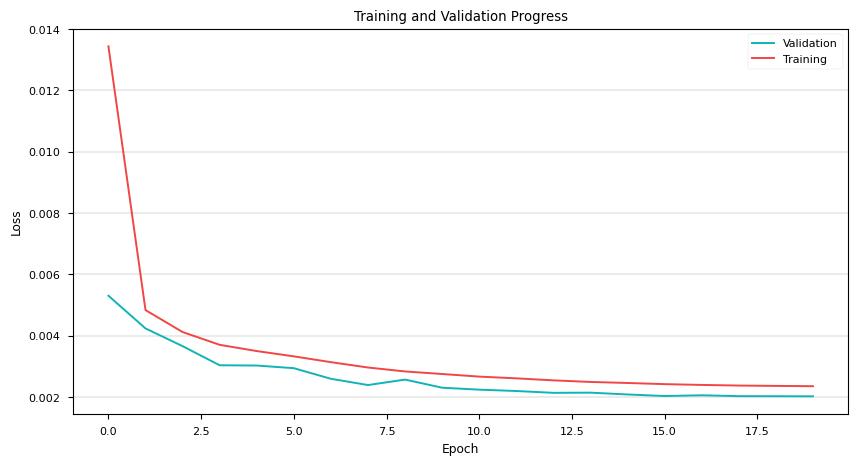

In [512]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "train_args": {
        "model_name": GRU,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "device": 'cuda',
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/GRU",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        "label_len": 0,
        'd_model': 128,
        'c_in': 2,
        'c_out': 2,
        'num_layers': 1,
    },
}
model = train(**params3)

### 模型测试

In [513]:
def test(task_args, test_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    model = test_args['model'] 
    x_test = test_args['x_test'] 
    x_test_stamp = test_args['x_test_stamp']
    y_test = test_args['y_test'] 
    y_test_stamp = test_args['y_test_stamp']
    pred_len = test_args['pred_len'] 
    label_len = test_args['label_len']
    device = test_args['device'] # 训练设备，可选'cuda'和'cpu'
    test_path = test_args['test_path'] # 结果保存路径
    
    #检查是否可用GPU
    device = torch.device(device)

    # 评估指标函数
    def metric(pred, true):
        # a/b，其中生成的 NaN 或 Inf 替换为 0
        def divide_no_nan(a, b):
            result = a / b
            result[result != result] = .0
            result[np.inf in result] = .0
            result[np.nan in result] = .0
            return result
        # 残差的标准误差
        def RSE(pred, true):
            return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))
        # 相关系数
        def CORR(pred, true):
            u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
            d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
            return (u / d).mean(-1)
        # 平均绝对误差
        def MAE(pred, true):
            return np.mean(np.abs(pred - true))
        # 均方误差
        def MSE(pred, true):
            return np.mean((pred - true) ** 2)
        # 均方根误差
        def RMSE(pred, true):
            return np.sqrt(MSE(pred, true))
        # 平均绝对百分比误差
        def MAPE(pred, true):
            return np.mean(np.abs(divide_no_nan((pred - true), true)))
        # 均方预测误差
        def MSPE(pred, true):
            return np.mean(np.square(divide_no_nan((pred - true), true)))
        # 结果汇总
        mae = MAE(pred, true)
        mse = MSE(pred, true)
        rmse = RMSE(pred, true)
        mape = MAPE(pred, true)
        mspe = MSPE(pred, true)
        print("mae: {:.4f}\nmse: {:.4f}\nrmse: {:.4f}\nmape: {:.4f}\nmspe: {:.4f}".format(mae, mse, rmse, mape, mspe))
        return mae, mse, rmse, mape, mspe
    
    def forecasting_task(columns, target, features):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0
        return f_dim
    f_dim = forecasting_task(columns, target, features)
    
    # 设置保存模型路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        dec_inp = torch.zeros_like(y_test[:, -pred_len:, :]).float()
        dec_inp = torch.cat([y_test[:, -label_len:, :], dec_inp], dim=1).float().to(device)
        outputs = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
        if features == 'MS':
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float().to(device)
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            # y_pred = outputs[:, :, f_dim: f_dim+1] 
        else:
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim:], dec_inp], dim=1).float().to(device)
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            # y_pred = outputs[:, :, f_dim:]
        # 评估指标计算
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_test.cpu().detach().numpy()
        mae, mse, rmse, mape, mspe = metric(y_pred, y_true)
        np.save(test_path + '/metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(test_path + '/pred.npy', y_pred)
        np.save(test_path + '/true.npy', y_true)
        
    return 0

In [514]:
# 构造参数字典
params4 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['load', 'temp'],
        "features": 'M'
    },
    "test_args": {
        "model": model,
        "x_test": X_test,
        "x_test_stamp": X_test_stamp,
        "y_test": y_test,
        "y_test_stamp": y_test_stamp,
        'label_len': 0,
        'pred_len': 3,
        'device': 'cuda',
        'test_path': '../outputs/results/GRU'
    }
}
res = test(**params4)

mae: 0.0341
mse: 0.0026
rmse: 0.0508
mape: 0.0866
mspe: 0.0194


### 结果分析

In [515]:
def plot(task_args, plot_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    features = task_args['features'] 
    drawing_point = plot_args['drawing_point'] # 绘图点
    model = plot_args['model'] 
    x_train = plot_args['x_train'] 
    x_train_stamp = plot_args['x_train_stamp']
    x_valid = plot_args['x_valid'] 
    x_valid_stamp = plot_args['x_valid_stamp']
    x_test = plot_args['x_test'] 
    x_test_stamp = plot_args['x_test_stamp']
    y_train = plot_args['y_train'] 
    y_train_stamp = plot_args['y_train_stamp']
    y_valid = plot_args['y_valid'] 
    y_valid_stamp = plot_args['y_valid_stamp']
    y_test = plot_args['y_test'] 
    y_test_stamp = plot_args['y_test_stamp']
    y_true = plot_args['y_true'] 
    seq_len = plot_args['seq_len']
    scaler = plot_args['scaler']
    pred_len = plot_args['pred_len'] 
    label_len = plot_args['label_len']
    device = plot_args['device'] # 训练设备，可选'cuda'和'cpu'
    option = plot_args['option'] # 绘图选项，可选'part','full'
    figure_path = plot_args['figure_path'] # 图片保存路径
    seq_len = seq_len - 1 # 包含当前时间点
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 任务分类
    def forecasting_task(columns, target, features, drawing_point):
        """
        features: [M, S, MS]; 
            M:multivariate predict multivariate, 
            S:univariate predict univariate, 
            MS:multivariate predict univariate'
        """
        # 字典索引生成
        col_dict = {}
        for i,j in enumerate(columns):
            col_dict[j] = i

        if features == 'MS':
            target = target[0]
            if target in columns:
                f_dim = col_dict[target]
            else:
                f_dim = 0
        elif features == 'S':
            f_dim = 0
        else:
            f_dim = 0

        if drawing_point in columns:
            d_dim = col_dict[drawing_point]
        else:
            d_dim = 0
        return f_dim, d_dim
    f_dim, d_dim = forecasting_task(columns, target, features, drawing_point)
        
    # 数据集长度
    train_size = len(x_train) + seq_len + pred_len
    valid_size = len(x_valid) + seq_len + pred_len
    test_size = len(x_test) + seq_len + pred_len
    
    # 时间序列形状
    timeseries_y = y_true.values[:, d_dim].reshape(-1, 1)
    timeseries_x = y_true.index
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''训练集设置'''
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_train_stamp = x_train_stamp.to(device)
        y_train_stamp = y_train_stamp.to(device)
        # decoder输入
        B, _, _ = x_train.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_train[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_train, x_train_stamp, dec_inp, y_train_stamp)
            y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_train[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_train, x_train_stamp, dec_inp, y_train_stamp)
            y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
        train_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        x_valid_stamp = x_valid_stamp.to(device)
        y_valid_stamp = y_valid_stamp.to(device)
        # decoder输入
        B, _, _ = x_valid.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_valid[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_valid, x_valid_stamp, dec_inp, y_valid_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_valid[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_valid, x_valid_stamp, dec_inp, y_valid_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
        valid_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_stamp = x_test_stamp.to(device)
        y_test_stamp = y_test_stamp.to(device)
        # decoder输入
        B, _, _ = x_test.shape
        dec_inp = torch.zeros((B, pred_len, len(target))).float().to(device)
        if features == 'S' or features == 'M':
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim:], dec_inp], dim=1).float()
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
            y_pred = y_pred[:, d_dim:d_dim+1]
        else:
            dec_inp = torch.cat([x_test[:, -label_len:, f_dim: f_dim+1], dec_inp], dim=1).float()
            y_pred = model(x_test, x_test_stamp, dec_inp, y_test_stamp)
            y_pred = y_pred.cpu().detach().numpy() 
            y_pred = scaler.inverse_transform(y_pred[:, 0, :].reshape(-1, len(columns))) # 反归一化
        test_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, )) + [np.nan]*(pred_len-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
        
    # 设置保存图片路径
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    figure_path = figure_path + '/' + target[0] + '_' + option + '.png'

    # 全局静态图
    def static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path):
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
        ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
        ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 局部静态图
    def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 全局动态图
    def dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加训练预测数据
        fig.add_trace(
            go.Scatter(
                x=train_plot_x,
                y=train_plot_y,
                mode='lines',
                name='train_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加验证预测数据
        fig.add_trace(
            go.Scatter(
                x=valid_plot_x,
                y=valid_plot_y,
                mode='lines',
                name='valid_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='test_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 局部动态图
    def dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 绘图选项，可选'part','full','dynamic_part','dynamic_full'
    if option == 'part':
        # 局部静态图
        static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'full':
        # 全局静态图
        static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'dynamic_full':
        # 全局动态图
        dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)
    elif option == 'dynamic_part':
        # 局部动态图
        dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y)
    else:
        raise ValueError("only support 'part','full','dynamic_part','dynamic_part'")
        
    return 0

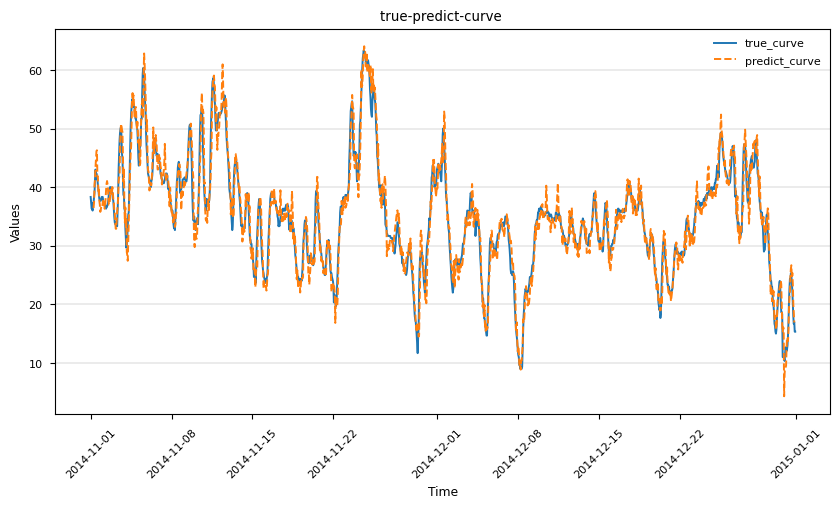

0

In [516]:
# 构造参数字典
params5 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "plot_args": {
        "model": model,
        "x_train": X_train,
        "x_valid": X_valid,
        "x_test": X_test,
        "y_true": ts_data,
        "seq_len": 6,
        "pred_len": 3,
        "scaler": y_scaler,
        "device": 'cuda',
        "option": 'part',
        "figure_path": '../outputs/images/CNN'
    }
}
plot(**params5)

### 模型预测

In [517]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    time_col = predict_args['time_col']
    freq = predict_args['freq']
    model_name = predict_args['model_name'] 
    x_true = predict_args['x_true'] 
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path'] 
    device = predict_args['device'] # 预测设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] 
    seq_len = model_args['seq_len']

    #检查是否可用GPU
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 生成固定长度的时间范围
    x_true = get_dataset(data_path=None, data=x_true, time_col=time_col) # 原始数据
    x_true = x_true[columns]
    timedelta = x_true.index[-1] - x_true.index[-2] # 时间差
    y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(0+1), 
                            end=x_true.index[-1]+timedelta*(0+pred_len), 
                            freq=freq) 
    y_time = y_stamp

    # 转换类型
    x_true[columns] = x_scaler.transform(x_true) # 归一化
    x_true = x_true.values.astype('float32')
    x_true = torch.as_tensor(x_true).unsqueeze(0).float() # 转为张量

    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        x_true = x_true.to(device)
        y_pred = model(x_true)
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = y_scaler.inverse_transform(y_pred) #反归一化

    # 输出为dataframe
    y_pred = pd.DataFrame(data=y_pred.transpose(1, 0), index=y_time[-pred_len:], columns=target)
    
    return y_pred

In [518]:
# 构造参数字典
params6 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": CNN,
        "model_path": "../outputs/best_models/CNN/checkpoint.pth",
        "x_true": pd.read_csv(data_path).iloc[:6, :],
        "scaler_path": '../outputs/scalers/CNN',
        "device": 'cpu', 
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3, 
        'd_model': 128,
        'c_in': 2,
        'num_layers': 1,
    },
}
y_pred = predict(**params6)

In [519]:
y_pred

,load,temp
2012-01-01 06:00:00,3079.218994,29.564217
2012-01-01 07:00:00,3187.498047,31.772844
2012-01-01 08:00:00,3227.411133,32.106060


# 基于CNN（卷积神经网络）的时间序列预测

多输入多输出多步预测可以做，但精度太差。

**数据输入维度一般为(样本数,特征,时间步)**

## 多输入单输出多步预测

### 数据准备

In [3]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [531]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [3]:
# 包含时间维度的数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    #验证集
    valid = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
    valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
    valid_stamp = valid_stamp.transpose(1, 0)
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')
    yva = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')
    valid = [xva, yva, valid_stamp]

    #测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]
    
    return x_scaler, y_scaler, train, valid, test

In [548]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ["load"],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/CNN'
}

#函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [7]:
#利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, batch_size):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0] # 特征
    target = data_list[1] # 目标
    
    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []
    seq_len = seq_len - 1 # 包含当前时间点
    for i in range(seq_len, len(feature) - pred_len):
        # 数据维度
        feat = feature[i - seq_len:i + 1]
        tar = target[i + 1:i + 1 + pred_len]
        X.append(feat)
        y.append(tar)
        
    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()
    y = y.squeeze(dim=2) # 去掉维度为1的第三维度，将其变为二维

    # 创建dataloader，[特征，目标]
    data_loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    
    return X, y, data_loader

In [550]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "batch_size": 32,
}
X_train, y_train, train_loader = generator(train_data, **params2)
X_valid, y_valid, valid_loader = generator(valid_data, **params2)
X_test, y_test, test_loader = generator(test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3]),loader_len: 46


### 模型定义

In [551]:
# 一维CNN模型
class CNN(nn.Module):
    def __init__(self, seq_len, pred_len, c_in, d_model, num_layers):
        super(CNN, self).__init__()
        layers = []
        in_channels = c_in
        for _ in range(num_layers):
            # 保证输出维度不变，kernel_size=3,padding=1,stride=1
            layers.append(nn.Conv1d(in_channels=in_channels,
                                    out_channels=d_model,
                                    kernel_size=3,
                                    padding=1))
            layers.append(nn.ReLU())
            in_channels = d_model  # 调整输入通道数
        # kernel_size： 池化窗口的大小，用于指定在每个维度上池化操作的窗口大小。
        # stride： 池化操作的步幅，用于指定在每个维度上滑动池化窗口的步幅。
        # padding： 输入的每一边添加零值的数量，以控制池化操作的形状。
        # dilation： 池化窗口中元素之间的间隔，可以用于增加感受野。
        self.pool = nn.MaxPool1d(kernel_size=2,
                                 stride=2,
                                 padding=0,
                                 dilation=1)  # 长度减少了一半
        self.conv_layers = nn.Sequential(*layers)
        # 将多维的输入数据展平为一维
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=(in_channels//2)*seq_len,
                             out_features=d_model)
        self.fc2 = nn.Linear(d_model, pred_len)

    def forward(self, x):
        x = x.permute(0, 2, 1) # 将输入维度变换为(样本数,特征,时间步)
        x = self.conv_layers(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

### 模型训练

In [552]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) # 会用到实际数据
            batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x)
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) # 会用到实际数据
                batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:03<01:15,  3.98s/it]

Epoch [1/20], Training Loss: 0.0034, Validation Loss: 0.0006
Validation loss decreased (inf --> 0.000635).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:07<01:09,  3.89s/it]

Epoch [2/20], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000635 --> 0.000539).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [00:11<01:06,  3.91s/it]

Epoch [3/20], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000539 --> 0.000514).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [00:15<01:01,  3.86s/it]

Epoch [4/20], Training Loss: 0.0005, Validation Loss: 0.0005
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [00:19<00:57,  3.83s/it]

Epoch [5/20], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000514 --> 0.000420).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [00:22<00:52,  3.75s/it]

Epoch [6/20], Training Loss: 0.0005, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [00:26<00:48,  3.76s/it]

Epoch [7/20], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000420 --> 0.000415).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [00:30<00:45,  3.77s/it]

Epoch [8/20], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [00:34<00:41,  3.80s/it]

Epoch [9/20], Training Loss: 0.0004, Validation Loss: 0.0005
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.0005782172325201155


 45%|█████████████████████████████████████▎                                             | 9/20 [00:38<00:46,  4.24s/it]

Epoch [10/20], Training Loss: 0.0004, Validation Loss: 0.0005
EarlyStopping counter: 3 out of 3
Early stopping!


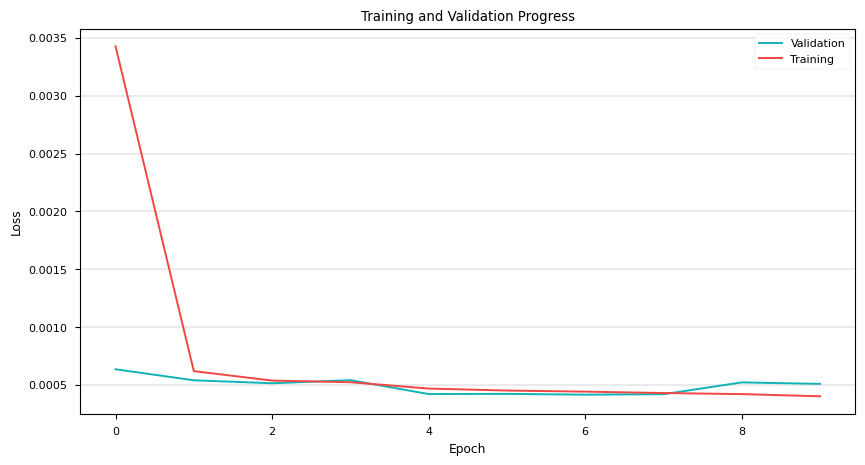

In [553]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "train_args": {
        "model_name": CNN,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "device": 'cuda',
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/CNN",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3,
        'd_model': 128,
        'c_in': 2,
        'num_layers': 1
    },
}
model = train(**params3)

### 模型测试

In [554]:
def test(task_args, test_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    model = test_args['model'] 
    x_test = test_args['x_test'] 
    y_test = test_args['y_test'] 
    device = test_args['device'] # 训练设备，可选'cuda'和'cpu'
    test_path = test_args['test_path'] # 结果保存路径
    
    #检查是否可用GPU
    device = torch.device(device)

    # 评估指标函数
    def metric(pred, true):
        # a/b，其中生成的 NaN 或 Inf 替换为 0
        def divide_no_nan(a, b):
            result = a / b
            result[result != result] = .0
            result[np.inf in result] = .0
            result[np.nan in result] = .0
            return result
        # 残差的标准误差
        def RSE(pred, true):
            return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))
        # 相关系数
        def CORR(pred, true):
            u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
            d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
            return (u / d).mean(-1)
        # 平均绝对误差
        def MAE(pred, true):
            return np.mean(np.abs(pred - true))
        # 均方误差
        def MSE(pred, true):
            return np.mean((pred - true) ** 2)
        # 均方根误差
        def RMSE(pred, true):
            return np.sqrt(MSE(pred, true))
        # 平均绝对百分比误差
        def MAPE(pred, true):
            return np.mean(np.abs(divide_no_nan((pred - true), true)))
        # 均方预测误差
        def MSPE(pred, true):
            return np.mean(np.square(divide_no_nan((pred - true), true)))
        # 结果汇总
        mae = MAE(pred, true)
        mse = MSE(pred, true)
        rmse = RMSE(pred, true)
        mape = MAPE(pred, true)
        mspe = MSPE(pred, true)
        print("mae: {:.4f}\nmse: {:.4f}\nrmse: {:.4f}\nmape: {:.4f}\nmspe: {:.4f}".format(mae, mse, rmse, mape, mspe))
        return mae, mse, rmse, mape, mspe
    
    # 设置保存模型路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(x_test)
        # 评估指标计算
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_test.cpu().detach().numpy()
        mae, mse, rmse, mape, mspe = metric(y_pred, y_true)
        np.save(test_path + '/metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(test_path + '/pred.npy', y_pred)
        np.save(test_path + '/true.npy', y_true)
        
    return 0

In [555]:
# 构造参数字典
params4 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "test_args": {
        "model": model,
        "x_test": X_test,
        "y_test": y_test,
        'device': 'cuda',
        'test_path': '../outputs/results/CNN'
    }
}
res = test(**params4)

mae: 0.0130
mse: 0.0003
rmse: 0.0171
mape: 0.0296
mspe: 0.0016


### 结果分析

In [556]:
def plot(task_args, plot_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    model = plot_args['model'] 
    x_train = plot_args['x_train'] 
    x_valid = plot_args['x_valid'] 
    x_test = plot_args['x_test'] 
    y_true = plot_args['y_true'] 
    scaler = plot_args['scaler']
    seq_len = plot_args['seq_len']
    pred_len = plot_args['pred_len'] 
    device = plot_args['device'] # 训练设备，可选'cuda'和'cpu'
    option = plot_args['option'] # 绘图选项，可选'part','full'
    figure_path = plot_args['figure_path'] # 图片保存路径
    seq_len = seq_len - 1 # 包含当前时间点
    
    #检查是否可用GPU
    device = torch.device(device)
        
    # 数据集长度
    train_size = len(x_train) + seq_len + pred_len
    valid_size = len(x_valid) + seq_len + pred_len
    test_size = len(x_test) + seq_len + pred_len
    
    # 时间序列形状
    timeseries_y = y_true[target].values
    timeseries_x = y_true.index
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''训练集设置'''
        x_train = x_train.to(device)
        outputs = model(x_train)
        y_pred = outputs[:,-1:] # 取最后一个预测值
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        x_valid = x_valid.to(device)
        outputs = model(x_valid)
        y_pred = outputs[:,-1:] # 取最后一个预测值
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        valid_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        x_test = x_test.to(device)
        outputs = model(x_test)
        y_pred = outputs[:,-1:] # 取最后一个预测值
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        test_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, )) + [np.nan]*(pred_len-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
        
    # 设置保存图片路径
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    figure_path = figure_path + '/' + target[0] + '_' + option + '.png'

    # 全局静态图
    def static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path):
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
        ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
        ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 局部静态图
    def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 全局动态图
    def dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加训练预测数据
        fig.add_trace(
            go.Scatter(
                x=train_plot_x,
                y=train_plot_y,
                mode='lines',
                name='train_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加验证预测数据
        fig.add_trace(
            go.Scatter(
                x=valid_plot_x,
                y=valid_plot_y,
                mode='lines',
                name='valid_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='test_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 局部动态图
    def dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 绘图选项，可选'part','full','dynamic_part','dynamic_full'
    if option == 'part':
        # 局部静态图
        static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'full':
        # 全局静态图
        static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'dynamic_full':
        # 全局动态图
        dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)
    elif option == 'dynamic_part':
        # 局部动态图
        dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y)
    else:
        raise ValueError("only support 'part','full','dynamic_part','dynamic_part'")
        
    return 0

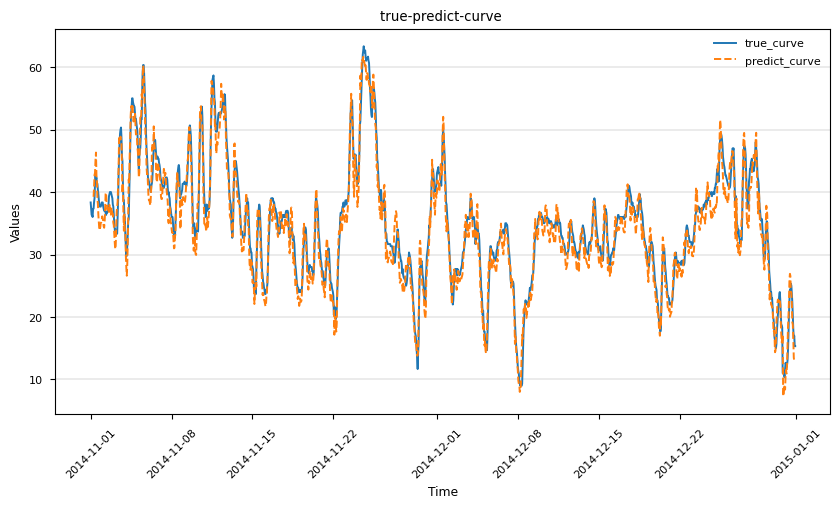

0

In [558]:
# 构造参数字典
params5 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "plot_args": {
        "model": model,
        "x_train": X_train,
        "x_valid": X_valid,
        "x_test": X_test,
        "y_true": ts_data,
        "seq_len": 6,
        "pred_len": 3,
        "scaler": y_scaler,
        "device": 'cuda',
        "option": 'part',
        "figure_path": '../outputs/images/CNN'
    }
}
plot(**params5)

### 模型预测

In [565]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    time_col = predict_args['time_col']
    freq = predict_args['freq']
    model_name = predict_args['model_name'] 
    x_true = predict_args['x_true'] 
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path'] 
    device = predict_args['device'] # 预测设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] 
    seq_len = model_args['seq_len']

    #检查是否可用GPU
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 生成固定长度的时间范围
    x_true = get_dataset(data_path=None, data=x_true, time_col=time_col) # 原始数据
    x_true = x_true[columns]
    timedelta = x_true.index[-1] - x_true.index[-2] # 时间差
    y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(0+1), 
                            end=x_true.index[-1]+timedelta*(0+pred_len), 
                            freq=freq) 
    y_time = y_stamp

    # 转换类型
    x_true[columns] = x_scaler.transform(x_true) # 归一化
    x_true = x_true.values.astype('float32')
    x_true = torch.as_tensor(x_true).unsqueeze(0).float() # 转为张量

    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        x_true = x_true.to(device)
        y_pred = model(x_true)
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = y_scaler.inverse_transform(y_pred) #反归一化

    # 输出为dataframe
    y_pred = pd.DataFrame(data=y_pred.transpose(1, 0), index=y_time[-pred_len:], columns=target)
    
    return y_pred

In [566]:
# 构造参数字典
params6 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": CNN,
        "model_path": "../outputs/best_models/CNN/checkpoint.pth",
        "x_true": pd.read_csv(data_path).iloc[:6, :],
        "scaler_path": '../outputs/scalers/CNN',
        "device": 'cpu', 
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3, 
        'd_model': 128,
        'c_in': 2,
        'num_layers': 1,
    },
}
y_pred = predict(**params6)

In [567]:
y_pred

,temp
2012-01-01 06:00:00,31.679142
2012-01-01 07:00:00,31.534897
2012-01-01 08:00:00,32.114807


# 基于TCN（时域卷积网络）的时间序列预测

## 算法原理

该算法于2016年由Lea等人他们在做视频动作分割的研究首先提出，TCN模型以 CNN 模型为基础，并做了如下改进：①适用序列模型：因果卷积（Causal Convolution）②记忆历史：空洞卷积/膨胀卷积（Dilated Convolution），残差模块（Residual block）。

 RNN耗时太长，由于网络一次只读取、解析输入文本中的一个单词（或字符），深度神经网络必须等前一个单词处理完，才能进行下一个单词的处理。这意味着 RNN 不能像 CNN 那样进行大规模并行处理；并且TCN的实际结果也要优于RNN算法。

TCN可以采用一系列任意长度并将其输出为相同长度。在使用一维完全卷积网络体系结构的情况下，使用因果卷积。一个关键特征是，时间t的输出仅与t之前发生的元素卷积。

### 因果卷积

![hellworld](../images/p29.png)

**因果卷积**可以用上图直观表示。 即对于上一层t时刻的值，只依赖于下一层t时刻及其之前的值。和传统的卷积神经网络的不同之处在于，因果卷积不能看到未来的数据，它是单向的结构，不是双向的。也就是说只有有了前面的因才有后面的果，是一种严格的时间约束模型，因此被成为因果卷积。

因果卷积有两个特点：
- 不考虑未来的信息。给定输入序列$x_1,x_2,...,x_T$ ，预测$y_1,y_2,...,y_T$ 。但是在预测$y_t$时，只能使用已经观测到的序列$x_1,x_2,...,x_T$ ，而不能使用$x_{t+1},x_{t+2},...$  。
- 追溯历史信息越久远，隐藏层越多。上图中，假设我们以第二层隐藏层作为输出，它的最后一个节点关联了输入的三个节点，即$x_{t-2},x_{t-1},x_t$  ；假设以输出层作为输出，它的最后一个节点关联了输入的五个节点。

### 空洞卷积/膨胀卷积

单纯的因果卷积还是存在传统卷积神经网络的问题，即对时间的建模长度受限于卷积核大小，如果要想抓去更长的依赖关系，就需要线性的堆叠很多的层。标准的 CNN 可以通过增加 pooling 层来获得更大的感受野，而经过 pooling 层后肯定存在信息损失的问题。

空洞卷积是在标准的卷积里注入空洞，以此来增加感受野。空洞卷积多了一个超参数 dilation rate，指的是 kernel 的间隔数量（标准的 CNN 中 dilatation rate 等于 1）。空洞的好处是不做 pooling 损失信息的情况下，增加了感受野，让每个卷积输出都包含较大范围的信息。 

扩张率大于1时，在标准卷积的基础上，会注入空洞，空洞中的数值全部填0。

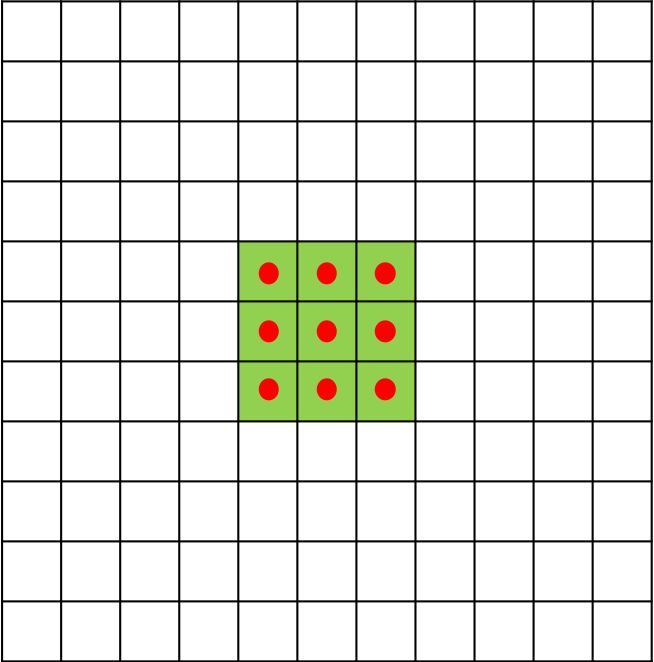
<center style="font-size:14px;color:#C0C0C0;text-decoration:underline"> 扩张率为1时的3*3空洞卷积</center> 

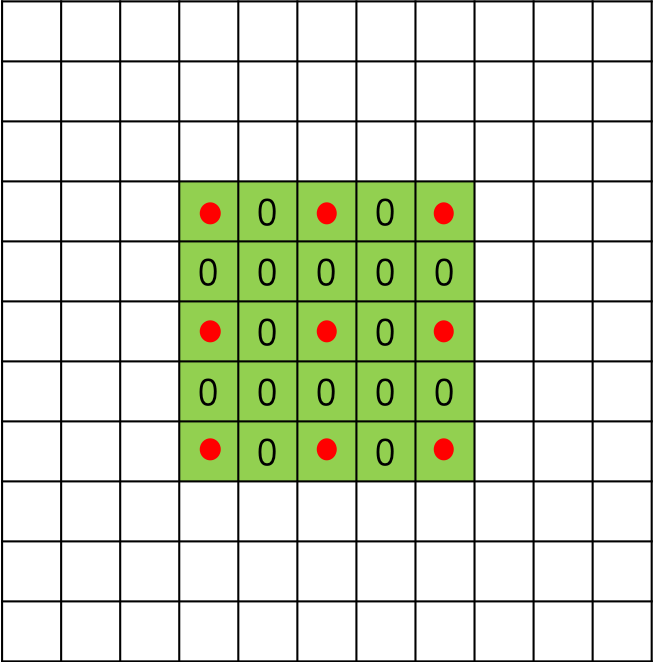
<center style="font-size:14px;color:#C0C0C0;text-decoration:underline"> 扩张率为2时的3*3空洞卷积</center> 

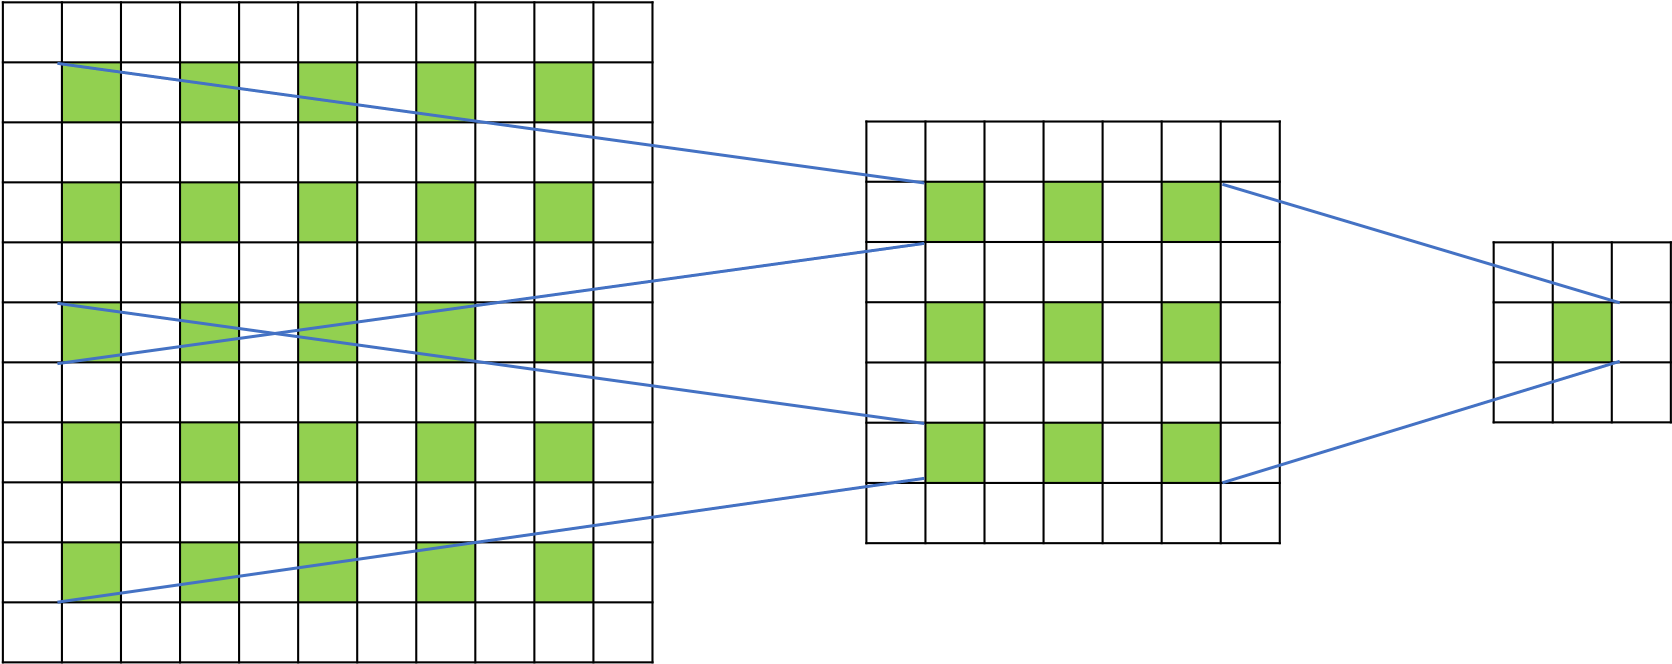
<center style="font-size:14px;color:#C0C0C0;text-decoration:underline"> 空洞卷积的感受野示例</center>

和传统卷积不同的是，膨胀卷积允许卷积时的输入存在间隔采样，采样率受图中的d控制。 最下面一层的d=1，表示输入时每个点都采样，中间层d=2，表示输入时每2个点采样一个作为输入。一般来讲，越高的层级使用的d的大小越大。所以，膨胀卷积使得有效窗口的大小随着层数呈指数型增长。这样卷积网络用比较少的层，就可以获得很大的感受野。

![hellworld](../images/p31.png)

因为研究对象是时间序列，TCN 采用一维的卷积网络。上图是 TCN 架构中的因果卷积与空洞卷积，可以看到每一层t时刻的值只依赖于上一层t,t-1,...时刻的值，体现了因果卷积的特性；而每一层对上一层信息的提取，都是跳跃式的，且逐层 dilated rate 以 2 的指数增长，体现了空洞卷积的特性。由于采用了空洞卷积，因此每一层都要做 padding（通常情况下补 0），padding 的大小为 (k-1)d 。 

### 残差模块

![hellworld](../images/p32.png)

残差链接被证明是训练深层网络的有效方法，它使得网络可以以跨层的方式传递信息。本文构建了一个残差块来代替一层的卷积。如上图所示，一个残差块包含两层的卷积和非线性映射，在每层中还加入了WeightNorm和Dropout来正则化网络。

优点：
- **并行性（Parallelism）**。与在 RNN 中对后续时间步的预测必须等待其前任完成的情况不同，卷积可以并行完成，因为每一层都使用相同的滤波器。因此，在训练和评估中，长输入序列可以在 TCN 中作为一个整体进行处理，而不是像在 RNN 中那样按顺序处理。
- **灵活的感受野大小（Flexible receptive field size）**。TCN 可以通过多种方式改变其感受野大小。例如，堆叠更多扩张（因果）卷积层、使用更大的膨胀因子或增加滤波器大小都是可行的选择（可能有不同的解释）。因此，TCN 可以更好地控制模型的内存大小，并且易于适应不同的领域。
- **稳定的梯度（Stable gradients）**。与循环架构不同，TCN 的反向传播路径与序列的时间方向不同。因此，TCN 避免了梯度爆炸/消失的问题，这是 RNN 的一个主要问题，并导致了 LSTM、GRU、HF-RNN（Martens & Sutskever，2011）等的发展。
- **训练时内存要求低**。特别是在输入序列较长的情况下，LSTM 和 GRU 很容易占用大量内存来存储它们的多个单元门的部分结果。而在 TCN 中，滤波器跨层共享，反向传播路径仅取决于网络深度。因此，在实践中，我们发现门控 RNN 可能比 TCN 使用更多的内存。
- **可变长度输入**。就像 RNN 以循环方式对可变长度的输入进行建模一样，TCN 也可以通过滑动 1D 卷积核来接收任意长度的输入。这意味着 TCN 可以作为 RNN 的替代品，用于任意长度的序列数据。

缺点：
- **评估期间的数据存储**。在评估/测试中，RNN 只需保持隐藏状态并获取当前输入 xt 即可生成预测。换句话说，整个历史的“摘要”由一组固定长度的向量 ht 提供，而实际观察到的序列可以被丢弃。相比之下，TCN 需要接收到有效历史长度的原始序列，因此在评估期间可能需要更多内存。
- **域迁移的潜在参数变化（Potential parameter change for a transfer of domain）**。不同领域对模型预测所需的历史数量可能有不同的要求。因此，当将模型从只需要很少内存的域（即小 k 和 d）转移到需要更长内存的域（即大得多的 k 和 d）时，TCN 可能会因为没有足够大的感受野。

## 多输入单输出多步预测

### 数据准备

In [4]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [602]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [4]:
# 包含时间维度的数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    #验证集
    valid = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
    valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
    valid_stamp = valid_stamp.transpose(1, 0)
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')
    yva = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')
    valid = [xva, yva, valid_stamp]

    #测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]
    
    return x_scaler, y_scaler, train, valid, test

In [604]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ["load", 'temp'],
    "y_feature_list": ['temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/TCN'
}

#函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [8]:
#利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, batch_size):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0] # 特征
    target = data_list[1] # 目标
    
    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []
    seq_len = seq_len - 1 # 包含当前时间点
    for i in range(seq_len, len(feature) - pred_len):
        # 数据维度
        feat = feature[i - seq_len:i + 1]
        tar = target[i + 1:i + 1 + pred_len]
        X.append(feat)
        y.append(tar)
        
    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()
    y = y.squeeze(dim=2) # 去掉维度为1的第三维度，将其变为二维

    # 创建dataloader，[特征，目标]
    data_loader = DataLoader(TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    
    return X, y, data_loader

In [577]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "batch_size": 32,
}
X_train, y_train, train_loader = generator(train_data, **params2)
X_valid, y_valid, valid_loader = generator(valid_data, **params2)
X_test, y_test, test_loader = generator(test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23368, 6, 2]),y_size: torch.Size([23368, 3]),loader_len: 731
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3]),loader_len: 46
X_size: torch.Size([1456, 6, 2]),y_size: torch.Size([1456, 3]),loader_len: 46


### 模型定义

In [638]:
class Crop(nn.Module):
    def __init__(self, crop_size):
        super(Crop, self).__init__()
        self.crop_size = crop_size

    def forward(self, x):
        # 裁剪输入张量以去除沿时间维度的多余填充
        return x[:, :, :-self.crop_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, input_dim, out_dim, kernel_size, stride, dilation, dropout=0.2):
        """
        时序因果层模块，由两个因果卷积块组成，每个卷积块包含卷积、裁剪、ReLU激活和丢弃部分。

        参数:
            - input_dim (int): 输入通道数。
            - out_dim (int): 输出通道数。
            - kernel_size (int): 卷积核大小。
            - stride (int): 卷积步幅。
            - dilation (int): 卷积膨胀率。
            - dropout (float): 丢弃率。
        """
        super(TemporalBlock, self).__init__()
        padding = (kernel_size - 1) * dilation
        conv_params = {
            'kernel_size': kernel_size,
            'stride': stride,
            'padding': padding,
            'dilation': dilation
        }

        # 第一个卷积块
        self.conv1 = weight_norm(nn.Conv1d(input_dim, out_dim, **conv_params))
        self.crop1 = Crop(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # 第二个卷积块
        self.conv2 = weight_norm(nn.Conv1d(out_dim, out_dim, **conv_params))
        self.crop2 = Crop(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # 两个卷积块的顺序组合
        self.net = nn.Sequential(self.conv1, self.crop1, self.relu1, self.dropout1,
                                 self.conv2, self.crop2, self.relu2, self.dropout2)

        # 快捷连接
        self.bias = nn.Conv1d(input_dim, out_dim, 1) if input_dim != out_dim else None
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        前向传播方法。

        参数:
            - x (Tensor): 输入张量，形状为 (batch_size, input_channels, sequence_length)。

        返回:
            - Tensor: 输出张量，形状为 (batch_size, output_channels, sequence_length)。
        """
        # 应用因果卷积和快捷连接
        y = self.net(x)
        b = x if self.bias is None else self.bias(x)
        return self.relu(y + b)

class TemporalConvNet(nn.Module):
    def __init__(self, input_dim, input_dims, kernel_size=2, dropout=0.2):
        """
        时序卷积网络模块，由多个时序因果层组成，每个时序因果层采用不同膨胀率的卷积核。

        参数:
            - input_dim (int): 输入通道数。
            - input_dims (list): 包含每个时序因果层输出通道数的列表。
            - kernel_size (int): 卷积核大小。
            - dropout (float): 丢弃率。
        """
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(input_dims)
        tcl_param = {
            'kernel_size': kernel_size,
            'stride': 1,
            'dropout': dropout
        }

        # 堆叠多个时序因果层
        for i in range(num_levels):
            dilation = 2 ** i
            input_dim = input_dim if i == 0 else input_dims[i - 1]
            out_dim = input_dims[i]
            tcl_param['dilation'] = dilation
            tcl = TemporalBlock(input_dim, out_dim, **tcl_param)
            layers.append(tcl)

        # 时序因果层的顺序组合
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        前向传播方法。

        参数:
            - x (Tensor): 输入张量，形状为 (batch_size, input_channels, sequence_length)。

        返回:
            - Tensor: 输出张量，形状为 (batch_size, output_channels, sequence_length)。
        """
        return self.network(x)

# TCN模型
class TCN(nn.Module):
    def __init__(self, c_in, c_out, c_ins, seq_len, pred_len, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        # 时间卷积网络
        self.tcn = TemporalConvNet(c_in, c_ins, kernel_size=kernel_size, dropout=dropout)
        # 用于最终预测的线性层，移除ReLU激活函数
        self.linear = nn.Linear(c_ins[-1], pred_len)

    def forward(self, x):
        """
        前向传播方法。

        参数:
            - x (Tensor): 输入张量，形状为 (batch_size, input_channels, sequence_length)。

        返回:
            - Tensor: 输出张量，形状为 (batch_size, out_dim)。
        """
        x = x.permute(0, 2, 1) # 将输入维度变换为(样本数,特征,时间步)
        # 应用时间卷积网络和线性层
        x = self.tcn(x)  # [N, C_out, L_out=L_in]
        x = self.linear(x[:, :, -1])
        return x

### 模型预测

In [639]:
def train(task_args, train_args, model_args):
    # 参数配置
    columns = task_args['columns'] # 模型全部特征
    target = task_args['target'] # 模型预测特征
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) # 会用到实际数据
            batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x)
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) # 会用到实际数据
                batch_y = batch_y.to(device) # 只用来获取维度，不会用到实际数据，防止泄露信息
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [00:07<02:17,  7.26s/it]

Epoch [1/20], Training Loss: 0.0034, Validation Loss: 0.0006
Validation loss decreased (inf --> 0.000555).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [00:14<02:09,  7.20s/it]

Epoch [2/20], Training Loss: 0.0006, Validation Loss: 0.0010
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [00:21<02:03,  7.28s/it]

Epoch [3/20], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000555 --> 0.000494).  Saving model ...
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [00:29<01:56,  7.29s/it]

Epoch [4/20], Training Loss: 0.0005, Validation Loss: 0.0005
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [00:36<01:50,  7.36s/it]

Epoch [5/20], Training Loss: 0.0005, Validation Loss: 0.0005
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [00:44<01:44,  7.50s/it]

Epoch [6/20], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000494 --> 0.000492).  Saving model ...
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [00:51<01:36,  7.46s/it]

Epoch [7/20], Training Loss: 0.0005, Validation Loss: 0.0005
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [00:59<01:30,  7.56s/it]

Epoch [8/20], Training Loss: 0.0005, Validation Loss: 0.0005
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [01:07<01:23,  7.56s/it]

Epoch [9/20], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000492 --> 0.000465).  Saving model ...
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [01:14<01:16,  7.62s/it]

Epoch [10/20], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000465 --> 0.000453).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [01:21<01:06,  7.44s/it]

Epoch [11/20], Training Loss: 0.0004, Validation Loss: 0.0005
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:28<00:58,  7.33s/it]

Epoch [12/20], Training Loss: 0.0004, Validation Loss: 0.0005
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [01:36<00:50,  7.26s/it]

Epoch [13/20], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000453 --> 0.000405).  Saving model ...
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:43<00:43,  7.22s/it]

Epoch [14/20], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000405 --> 0.000383).  Saving model ...
Updating learning rate to 0.00020610737385376348


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:50<00:36,  7.21s/it]

Epoch [15/20], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.00014644660940672628


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:57<00:28,  7.19s/it]

Epoch [16/20], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 3
Updating learning rate to 9.549150281252633e-05


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [02:04<00:31,  7.81s/it]

Epoch [17/20], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 3
Early stopping!


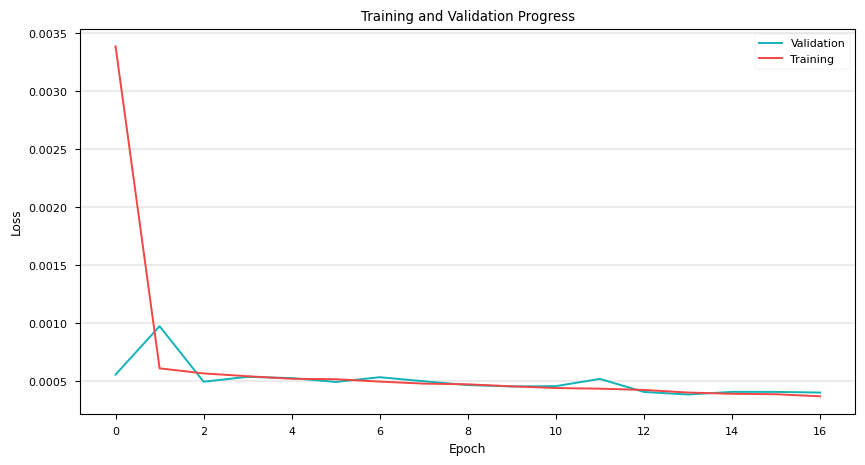

In [640]:
# 构造参数字典
params3 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "train_args": {
        "model_name": TCN,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "device": 'cuda',
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/TCN",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'c_in': 2,
        'c_out': 1,
        'seq_len': 6,
        'pred_len': 3,
        'c_ins': [64, 128, 256],
        'kernel_size': 2,
        'dropout': 0.2
    },
}
model = train(**params3)

### 模型测试

In [641]:
def test(task_args, test_args):
    # 参数配置
    columns = task_args['columns'] # 全部
    target = task_args['target'] 
    model = test_args['model'] 
    x_test = test_args['x_test'] 
    y_test = test_args['y_test'] 
    device = test_args['device'] # 训练设备，可选'cuda'和'cpu'
    test_path = test_args['test_path'] # 结果保存路径
    
    #检查是否可用GPU
    device = torch.device(device)

    # 评估指标函数
    def metric(pred, true):
        # a/b，其中生成的 NaN 或 Inf 替换为 0
        def divide_no_nan(a, b):
            result = a / b
            result[result != result] = .0
            result[np.inf in result] = .0
            result[np.nan in result] = .0
            return result
        # 残差的标准误差
        def RSE(pred, true):
            return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))
        # 相关系数
        def CORR(pred, true):
            u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
            d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
            return (u / d).mean(-1)
        # 平均绝对误差
        def MAE(pred, true):
            return np.mean(np.abs(pred - true))
        # 均方误差
        def MSE(pred, true):
            return np.mean((pred - true) ** 2)
        # 均方根误差
        def RMSE(pred, true):
            return np.sqrt(MSE(pred, true))
        # 平均绝对百分比误差
        def MAPE(pred, true):
            return np.mean(np.abs(divide_no_nan((pred - true), true)))
        # 均方预测误差
        def MSPE(pred, true):
            return np.mean(np.square(divide_no_nan((pred - true), true)))
        # 结果汇总
        mae = MAE(pred, true)
        mse = MSE(pred, true)
        rmse = RMSE(pred, true)
        mape = MAPE(pred, true)
        mspe = MSPE(pred, true)
        print("mae: {:.4f}\nmse: {:.4f}\nrmse: {:.4f}\nmape: {:.4f}\nmspe: {:.4f}".format(mae, mse, rmse, mape, mspe))
        return mae, mse, rmse, mape, mspe
    
    # 设置保存模型路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''测试集设置'''
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(x_test)
        # 评估指标计算
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_test.cpu().detach().numpy()
        mae, mse, rmse, mape, mspe = metric(y_pred, y_true)
        np.save(test_path + '/metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(test_path + '/pred.npy', y_pred)
        np.save(test_path + '/true.npy', y_true)
        
    return 0

In [642]:
# 构造参数字典
params4 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "test_args": {
        "model": model,
        "x_test": X_test,
        "y_test": y_test,
        'device': 'cuda',
        'test_path': '../outputs/results/TCN'
    }
}
res = test(**params4)

mae: 0.0104
mse: 0.0002
rmse: 0.0147
mape: 0.0236
mspe: 0.0011


### 结果分析

In [643]:
def plot(task_args, plot_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    model = plot_args['model'] 
    x_train = plot_args['x_train'] 
    x_valid = plot_args['x_valid'] 
    x_test = plot_args['x_test'] 
    y_true = plot_args['y_true'] 
    scaler = plot_args['scaler']
    seq_len = plot_args['seq_len']
    pred_len = plot_args['pred_len'] 
    device = plot_args['device'] # 训练设备，可选'cuda'和'cpu'
    option = plot_args['option'] # 绘图选项，可选'part','full'
    figure_path = plot_args['figure_path'] # 图片保存路径
    seq_len = seq_len - 1 # 包含当前时间点
    
    #检查是否可用GPU
    device = torch.device(device)
        
    # 数据集长度
    train_size = len(x_train) + seq_len + pred_len
    valid_size = len(x_valid) + seq_len + pred_len
    test_size = len(x_test) + seq_len + pred_len
    
    # 时间序列形状
    timeseries_y = y_true[target].values
    timeseries_x = y_true.index
    
    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        '''训练集设置'''
        x_train = x_train.to(device)
        outputs = model(x_train)
        y_pred = outputs[:,-1:] # 取最后一个预测值
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        train_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        x_valid = x_valid.to(device)
        outputs = model(x_valid)
        y_pred = outputs[:,-1:] # 取最后一个预测值
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        valid_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(pred_len-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        x_test = x_test.to(device)
        outputs = model(x_test)
        y_pred = outputs[:,-1:] # 取最后一个预测值
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) #反归一化
        test_plot_y = [np.nan]*(seq_len+1) + list(y_pred.reshape(-1, )) + [np.nan]*(pred_len-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
        
    # 设置保存图片路径
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    figure_path = figure_path + '/' + target[0] + '_' + option + '.png'

    # 全局静态图
    def static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path):
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',color = '#11b3b6',label = 'true_curve')
        ax.plot(train_plot_x, train_plot_y, linestyle='--',label = 'train_predict_curve')
        ax.plot(valid_plot_x, valid_plot_y, linestyle='--',label = 'valid_predict_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'test_predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 局部静态图
    def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.savefig(figure_path, dpi=600)
        plt.show()

    # 全局动态图
    def dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y):
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加训练预测数据
        fig.add_trace(
            go.Scatter(
                x=train_plot_x,
                y=train_plot_y,
                mode='lines',
                name='train_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加验证预测数据
        fig.add_trace(
            go.Scatter(
                x=valid_plot_x,
                y=valid_plot_y,
                mode='lines',
                name='valid_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='test_predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 局部动态图
    def dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
        timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
        timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
        # 准备画布
        fig = go.Figure()
    
        # 添加实际数据
        fig.add_trace(
            go.Scatter(
                x=timeseries_x,
                y=timeseries_y.reshape(timeseries_y.shape[0], ),
                mode='lines',
                name='true_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        # 添加测试预测数据
        fig.add_trace(
            go.Scatter(
                x=test_plot_x,
                y=test_plot_y,
                mode='lines',
                name='predict_curve',
                line = dict(color=None, width=2, dash=None)
            ))
    
        #更新图表的排版
        fig.update_layout(
            title='true-predict-curve',
            xaxis=dict(title="date"),
            yaxis=dict(title="values"),
            width=900,  #图表宽度
            height=500,  #图表长度
            template="simple_white"  #图表风格
        )
    
        fig.show()

    # 绘图选项，可选'part','full','dynamic_part','dynamic_full'
    if option == 'part':
        # 局部静态图
        static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'full':
        # 全局静态图
        static_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y, figure_path)
    elif option == 'dynamic_full':
        # 全局动态图
        dynamic_full_timeseries(timeseries_x, timeseries_y, train_plot_x, train_plot_y, 
                               valid_plot_x, valid_plot_y, test_plot_x, test_plot_y)
    elif option == 'dynamic_part':
        # 局部动态图
        dynamic_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y)
    else:
        raise ValueError("only support 'part','full','dynamic_part','dynamic_part'")
        
    return 0

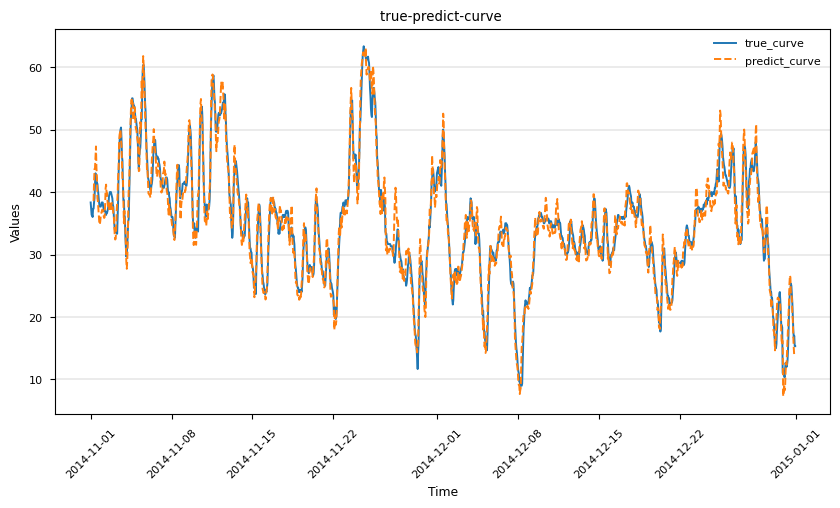

0

In [644]:
# 构造参数字典
params5 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "plot_args": {
        "model": model,
        "x_train": X_train,
        "x_valid": X_valid,
        "x_test": X_test,
        "y_true": ts_data,
        "seq_len": 6,
        "pred_len": 3,
        "scaler": y_scaler,
        "device": 'cuda',
        "option": 'part',
        "figure_path": '../outputs/images/TCN'
    }
}
plot(**params5)

### 模型预测

In [645]:
def predict(task_args, predict_args, model_args):
    # 参数配置
    columns = task_args['columns']
    target = task_args['target'] 
    time_col = predict_args['time_col']
    freq = predict_args['freq']
    model_name = predict_args['model_name'] 
    x_true = predict_args['x_true'] 
    scaler_path = predict_args['scaler_path']
    model_path = predict_args['model_path'] 
    device = predict_args['device'] # 预测设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len'] 
    seq_len = model_args['seq_len']

    #检查是否可用GPU
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 生成固定长度的时间范围
    x_true = get_dataset(data_path=None, data=x_true, time_col=time_col) # 原始数据
    x_true = x_true[columns]
    timedelta = x_true.index[-1] - x_true.index[-2] # 时间差
    y_stamp = pd.date_range(start=x_true.index[-1]+timedelta*(0+1), 
                            end=x_true.index[-1]+timedelta*(0+pred_len), 
                            freq=freq) 
    y_time = y_stamp

    # 转换类型
    x_true[columns] = x_scaler.transform(x_true) # 归一化
    x_true = x_true.values.astype('float32')
    x_true = torch.as_tensor(x_true).unsqueeze(0).float() # 转为张量

    # 关闭自动求导功能
    model.eval() # 一定要有
    with torch.no_grad():
        x_true = x_true.to(device)
        y_pred = model(x_true)
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = y_scaler.inverse_transform(y_pred) #反归一化

    # 输出为dataframe
    y_pred = pd.DataFrame(data=y_pred.transpose(1, 0), index=y_time[-pred_len:], columns=target)
    
    return y_pred

In [646]:
# 构造参数字典
params6 = {
    "task_args":{
        "columns": ['load', 'temp'],
        "target": ['temp'],
    },
    "predict_args": {
        "time_col": 'time',
        "freq": 'h',
        "model_name": TCN,
        "model_path": "../outputs/best_models/TCN/checkpoint.pth",
        "x_true": pd.read_csv(data_path).iloc[:6, :],
        "scaler_path": '../outputs/scalers/TCN',
        "device": 'cpu', 
    },
    "model_args": {
        'c_in': 2,
        'c_out': 1,
        'seq_len': 6,
        'pred_len': 3,
        'c_ins': [64, 128, 256],
        'kernel_size': 2,
        'dropout': 0.2
    },
}
y_pred = predict(**params6)

In [647]:
y_pred

,temp
2012-01-01 06:00:00,31.193893
2012-01-01 07:00:00,31.303503
2012-01-01 08:00:00,32.007610
